# Transformer Encoder model

In this notebook I will share a chunk of my solution, using the encoder of a Transformer. My solution isn't exactly like this but very close, I'm still trying to improve it. ~~~This notebook will only cover the training part, but it won't be hard to adpat the inference part. If it gets attention ;) I will add the inference portion of the code.~~

I'll try to make things easy to understand, meaning that I will copy-paste almost everything of the code from public resources where you can refer to. Also, the little code I'll develop will be both simple and scalable for you to be able to make something great from it.

If you have any suggestions I will be grateful :).

The majority of the model stuff is already implemented in multiple frameworks. We will use here some code in Tensorflow from [the official Transformer tutorial](https://www.tensorflow.org/tutorials/text/transformer).

We are taking into account the information given in our host's papers ([https://arxiv.org/abs/2002.07033](https://arxiv.org/abs/2002.07033), [https://arxiv.org/abs/2010.12042](https://arxiv.org/abs/2010.12042)), implementing a light version of their model. 

We will use embeddings for the following columns: 

- answered_correctly
- content_id
- task_container_id
- prior_elapsed_time (this one as continuous encoding)
- part

And also we will add some information about the position in a fixed sinusoidal fashion.


EDIT: As promised, I'm adding the inference portion of the code. Thanks for paying attention to my work.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so


In [2]:
dtype = {
    'answered_correctly': 'int8',
    # 'row_id': 'int64',
    # 'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    # 'content_type_id': 'int8',
    'task_container_id': 'int16',
    # 'user_answer': 'int8',
    'prior_question_elapsed_time': 'float32',
    # 'prior_question_had_explanation': 'boolean'
}

dtype_questions = {
    'question_id': 'int32',
    # 'bundle_id': 'int32',
    # 'correct_answer': 'int8',
    'part': 'int8',
    # 'tags': 'object',
}

## Data

We drop lectures, we are not using them here. Also we drop those interactions above 1500th. This can be changed if pleased.

In [3]:
df = pd.read_csv(
    '/kaggle/input/riiid-test-answer-prediction/train.csv',
    usecols=dtype.keys(),
    dtype=dtype,
    nrows=10**6
)
df = df[df.answered_correctly!=-1]
df = df.groupby('user_id').head(1500)

questions = pd.read_csv(
    '/kaggle/input/riiid-test-answer-prediction/questions.csv', 
    dtype=dtype_questions,
    usecols=dtype_questions.keys(),
    index_col='question_id'
)

### Basic transformation functions

We'll need to add one unit to the future embedding columns which has zero in them, as we are going to use the zero as the padding token. Then some non-fancy things.

In [4]:
def transform_questions(questions):
  part_ids = questions.part.max()+1
  return questions, part_ids


def transform_df(df, questions):
    df['prior_question_elapsed_time'] = df['prior_question_elapsed_time'].fillna(0).astype(np.float32)/300000
    content_ids = questions.index.max()+2
    df = df.join(questions, on='content_id')
    df['content_id'] += 1
    df['task_container_id'] += 1
    task_container_ids = 10001
    return df, content_ids, task_container_ids

In [5]:
questions, part_ids = transform_questions(questions)
df, content_ids, task_container_ids = transform_df(df, questions)
df.columns

Index(['user_id', 'content_id', 'task_container_id', 'answered_correctly',
       'prior_question_elapsed_time', 'part'],
      dtype='object')

### Grouping rows by user id and putting them in a hashtable

Maybe there's a better way to do this, please tell me!

In [6]:
df = {uid: u.drop(columns='user_id') for uid, u in df.groupby('user_id')}

## Data generator

We need a way to feed the data in the model. I'm subclassing here tf.keras.utils.Sequence. I think it can be faster/better with tf.data but I don't have much experience handling DataFrames with it. You're welcome again to help me here!

EDIT (inference addition): We are reusing the RiidSequence to store last windows_size users' interactions later in the inference part. For that, we need to add to new methods to it. We add a new property too to trace the column answered_correctly, so we can then know where to insert new values during the test iterations (prior_answered_correctly). Notice that we are now dealing directly with numpy arrays instead of DataFrames to inference faster. We transform DataFrames to numpy arrays on the fly when updating the users.

Also, we need something to shift our answer_correctly and something to make a time series from our user data. 

Notice that what we are doing is transforming a 2D tensor (one user interactions) to a 3D tensor by padding and then windowing the user. A user will serve then as a whole batch for the model.

For example, let's transform a random 2D tensor [5, 4] into a batch with window size of 3 [5, 3, 4]:

1.- User interaction:
```
array([[0.32147631, 0.21259791, 0.95322964, 0.82263467],
       [0.4595167 , 0.69536323, 0.64991227, 0.63098329],
       [0.34540743, 0.25885106, 0.57766127, 0.38967852],
       [0.26470928, 0.24314868, 0.86343302, 0.06009916],
       [0.72159549, 0.96692088, 0.18604403, 0.46528594]])
```       
2.- Add pad:
```
array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.32147631, 0.21259791, 0.95322964, 0.82263467],
       [0.4595167 , 0.69536323, 0.64991227, 0.63098329],
       [0.34540743, 0.25885106, 0.57766127, 0.38967852],
       [0.26470928, 0.24314868, 0.86343302, 0.06009916],
       [0.72159549, 0.96692088, 0.18604403, 0.46528594]])
```
3.- Roll a window to get a batch:
```
array([[[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.32147631, 0.21259791, 0.95322964, 0.82263467]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.32147631, 0.21259791, 0.95322964, 0.82263467],
        [0.4595167 , 0.69536323, 0.64991227, 0.63098329]],

       [[0.32147631, 0.21259791, 0.95322964, 0.82263467],
        [0.4595167 , 0.69536323, 0.64991227, 0.63098329],
        [0.34540743, 0.25885106, 0.57766127, 0.38967852]],

       [[0.4595167 , 0.69536323, 0.64991227, 0.63098329],
        [0.34540743, 0.25885106, 0.57766127, 0.38967852],
        [0.26470928, 0.24314868, 0.86343302, 0.06009916]],

       [[0.34540743, 0.25885106, 0.57766127, 0.38967852],
        [0.26470928, 0.24314868, 0.86343302, 0.06009916],
        [0.72159549, 0.96692088, 0.18604403, 0.46528594]]])
```

In [7]:
import tensorflow as tf

In [8]:
# just some stuff I ctrl C ctrl V from StackOverflow (with little changes)
# [1,2,3,4] --- w = 2 --[[1,2], [2,3], [3,4]] but 2D to 3D
def rolling_window(a, w):
    s0, s1 = a.strides
    m, n = a.shape
    return np.lib.stride_tricks.as_strided(
        a, 
        shape=(m-w+1, w, n), 
        strides=(s0, s0, s1)
    )


def make_time_series(x, windows_size):
  x = np.pad(x, [[ windows_size-1, 0], [0, 0]], constant_values=0)
  x = rolling_window(x, windows_size)
  return x


def add_features_to_user(user):
    # We add one to the column in order to have zeros as padding values
    # Start Of Sentence (SOS) token will be 3. 
    user['answered_correctly'] = user['answered_correctly'].shift(fill_value=2)+1
    return user


class RiidSequence(tf.keras.utils.Sequence):

  def __init__(self, 
               users, 
               windows_size,
               batch_size=256,
               start=0,
               end=None):
    self.users = users # {'user_id': user_df, ...}
    self.windows_size = windows_size
    # to convert indices to our keys
    self.mapper = dict(zip(range(len(users)), users.keys()))
    # start and end to easy generate training and validation
    self.start = start
    self.end = end if end else len(users)
    # To know where the answered_correctly_column is
    self.answered_correctly_index = list(self.user_example().columns).index('answered_correctly')
        
  def __len__(self):
    return self.end-self.start

  def __getitem__(self, idx):
    uid = self.mapper[idx+self.start]
    user = self.users[uid].copy()
    y = user['answered_correctly'].to_numpy().copy()
    x = add_features_to_user(user)
    return make_time_series(x, self.windows_size), y

  def user_example(self):
    """Just to check what we have till' now."""
    uid = self.mapper[self.start]
    return add_features_to_user(self.users[uid].copy())

  # INFERENCE PART    
  def get_user_for_inference(self, user_row):
    """Picks a new user row and concats it to previous interactions 
    if it was already stored.
    
    Maybe the biggest trick in the notebook is here. We reuse the user_id column to 
    insert the answered_correctly SOS token because we previously placed the column 
    there on purpose.
    
    After it, we roll that column and then crop it if it was bigger than the window
    size, making the SOS token disapear if out of the sequence.
    
    If the sequence if shorter than the window size, then we pad it.
    """
    uid = user_row[self.answered_correctly_index]
    user_row[self.answered_correctly_index] = 2 # SOS token
    user_row = user_row[np.newaxis, ...]
    if uid in self.users:
      x = np.concatenate([self.users[uid], user_row])
      # same as in training, we need to add one!!!
      x[:, self.answered_correctly_index] = np.roll(x[:, self.answered_correctly_index], 1) + 1
    else:
      x = user_row
     
    if x.shape[0] < self.windows_size:
      return np.pad(x, [[self.windows_size-x.shape[0], 0], [0, 0]])
    elif x.shape[0] > self.windows_size:
      return x[-self.windows_size:]
    else:
      return x

  def update_user(self, uid, user):
    """Concat the new user's interactions to the old ones if already stored."""
    if uid in self.users:
      self.users[uid] = \
        np.concatenate([self.users[uid], user])[-self.windows_size:]
    else:
      self.users[uid] = user

In [9]:
RiidSequence(df, 64).user_example().head()

,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,part
0,5693,2,3,0.000000,5
1,5717,3,2,0.123333,5
2,129,1,2,0.183333,1
3,7861,4,2,0.063333,1
4,7923,5,2,0.036667,1


In [10]:
x, y = RiidSequence(df, 64)[0]
x.shape, y.shape

((46, 64, 5), (46,))

So far so good.

## Modeling (fancy part)

I will copy paste some stuff we need from the page I linked at the beginning ([https://www.tensorflow.org/tutorials/text/transformer](https://www.tensorflow.org/tutorials/text/transformer)). I will only clean comments for readability.

In [11]:
# POSITION ENCODING

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates


def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

# NN THINGS
def scaled_dot_product_attention(q, k, v, mask):
  matmul_qk = tf.matmul(q, k, transpose_b=True)
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
  output = tf.matmul(attention_weights, v)
  return output, attention_weights

    
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    q = self.wq(q)
    k = self.wk(k)
    v = self.wv(v)

    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)

    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))

    output = self.dense(concat_attention)

    return output, attention_weights


def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model)
  ])


class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask) 
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output) 

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output) 

    return out2

This is a little more tricky. To create padding mask with Multivariate Time Series oriented data (3D) we will slightly modify the function from the reference link.

In [12]:
def create_padding_mask(seqs):
  # We mask only those vectors of the sequence in which we have all zeroes 
  # (this is more scalable for some situations).
  mask = tf.cast(tf.reduce_all(tf.math.equal(seqs, 0), axis=-1), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

And now our model. We are using the functional API for simplicity. We could also subclass tf.keras.Model for it, which is cleaner. 

To implement it, we will recall the columns we had before.

In [13]:
columns = list(RiidSequence(df, 64).user_example().columns)
columns

['content_id',
 'task_container_id',
 'answered_correctly',
 'prior_question_elapsed_time',
 'part']

In [14]:
def get_series_model(
        n_features,
        content_ids,
        task_container_ids,
        part_ids,
        windows_size=64,
        d_model=24,
        num_heads=4,
        n_encoder_layers = 2
    ):
    # Input
    inputs = tf.keras.Input(shape=(windows_size, n_features), name='inputs')
    mask = create_padding_mask(inputs)
    pos_enc = positional_encoding(windows_size, d_model)    
    
    # Divide branches
    content_id = inputs[..., 0]
    task_container_id = inputs[..., 1]
    answered_correctly = inputs[..., 2]
    elapsed_time = inputs[..., 3]
    part = inputs[..., 4]
    
    # Create embeddings
    content_embeddings = tf.keras.layers.Embedding(content_ids, d_model)(content_id)
    task_embeddings = tf.keras.layers.Embedding(task_container_ids, d_model)(task_container_id)
    answered_correctly_embeddings = tf.keras.layers.Embedding(4, d_model)(answered_correctly)
    # Continuous! Only a learnable layer for it.
    elapsed_time_embeddings = tf.keras.layers.Dense(d_model, use_bias=False)(elapsed_time)
    part_embeddings = tf.keras.layers.Embedding(part_ids, d_model)(part)
    
    # Add embeddings
    x = tf.keras.layers.Add()([
        pos_enc,
        content_embeddings,
        task_embeddings,
        answered_correctly_embeddings,
        elapsed_time_embeddings,
        part_embeddings,
    ])

    for _ in range(n_encoder_layers):
        x = EncoderLayer(d_model=d_model, num_heads=num_heads, dff=d_model*4, rate=0.1)(x, mask=mask)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)    
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)
    return tf.keras.Model(inputs, output, name='model')

As you can see, we have adapted the Encoder to output only one value per sequence, in oposition to the original implementation which outputs an entire sequence per every input sequence. That's why we don't have to add a look ahead mask.

## TRAIN!

In my implementation I have a learning rate scheduler. I removed it for simplicity. Feel free to add it.

For the example we will have a very little model just to show that it works!

In [15]:
train_idx = int(len(df)*0.8)
windows_size = 64
epochs = 300
patience = 2
d_model = 32
num_heads = 4
n_encoder_layers = 2

In [16]:
s_train = RiidSequence(df, windows_size, start=0, end=train_idx)
s_val = RiidSequence(df, windows_size, start=train_idx)

n_features = s_train[0][0].shape[-1]

tf.keras.backend.clear_session()
model = get_series_model(
        n_features,
        content_ids,
        task_container_ids,
        part_ids,
        windows_size=windows_size,
        d_model=d_model,
        num_heads=num_heads,
        n_encoder_layers=n_encoder_layers
    )

model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=[tf.keras.metrics.AUC(name='AUC'), tf.keras.metrics.BinaryAccuracy(name='acc')]
)

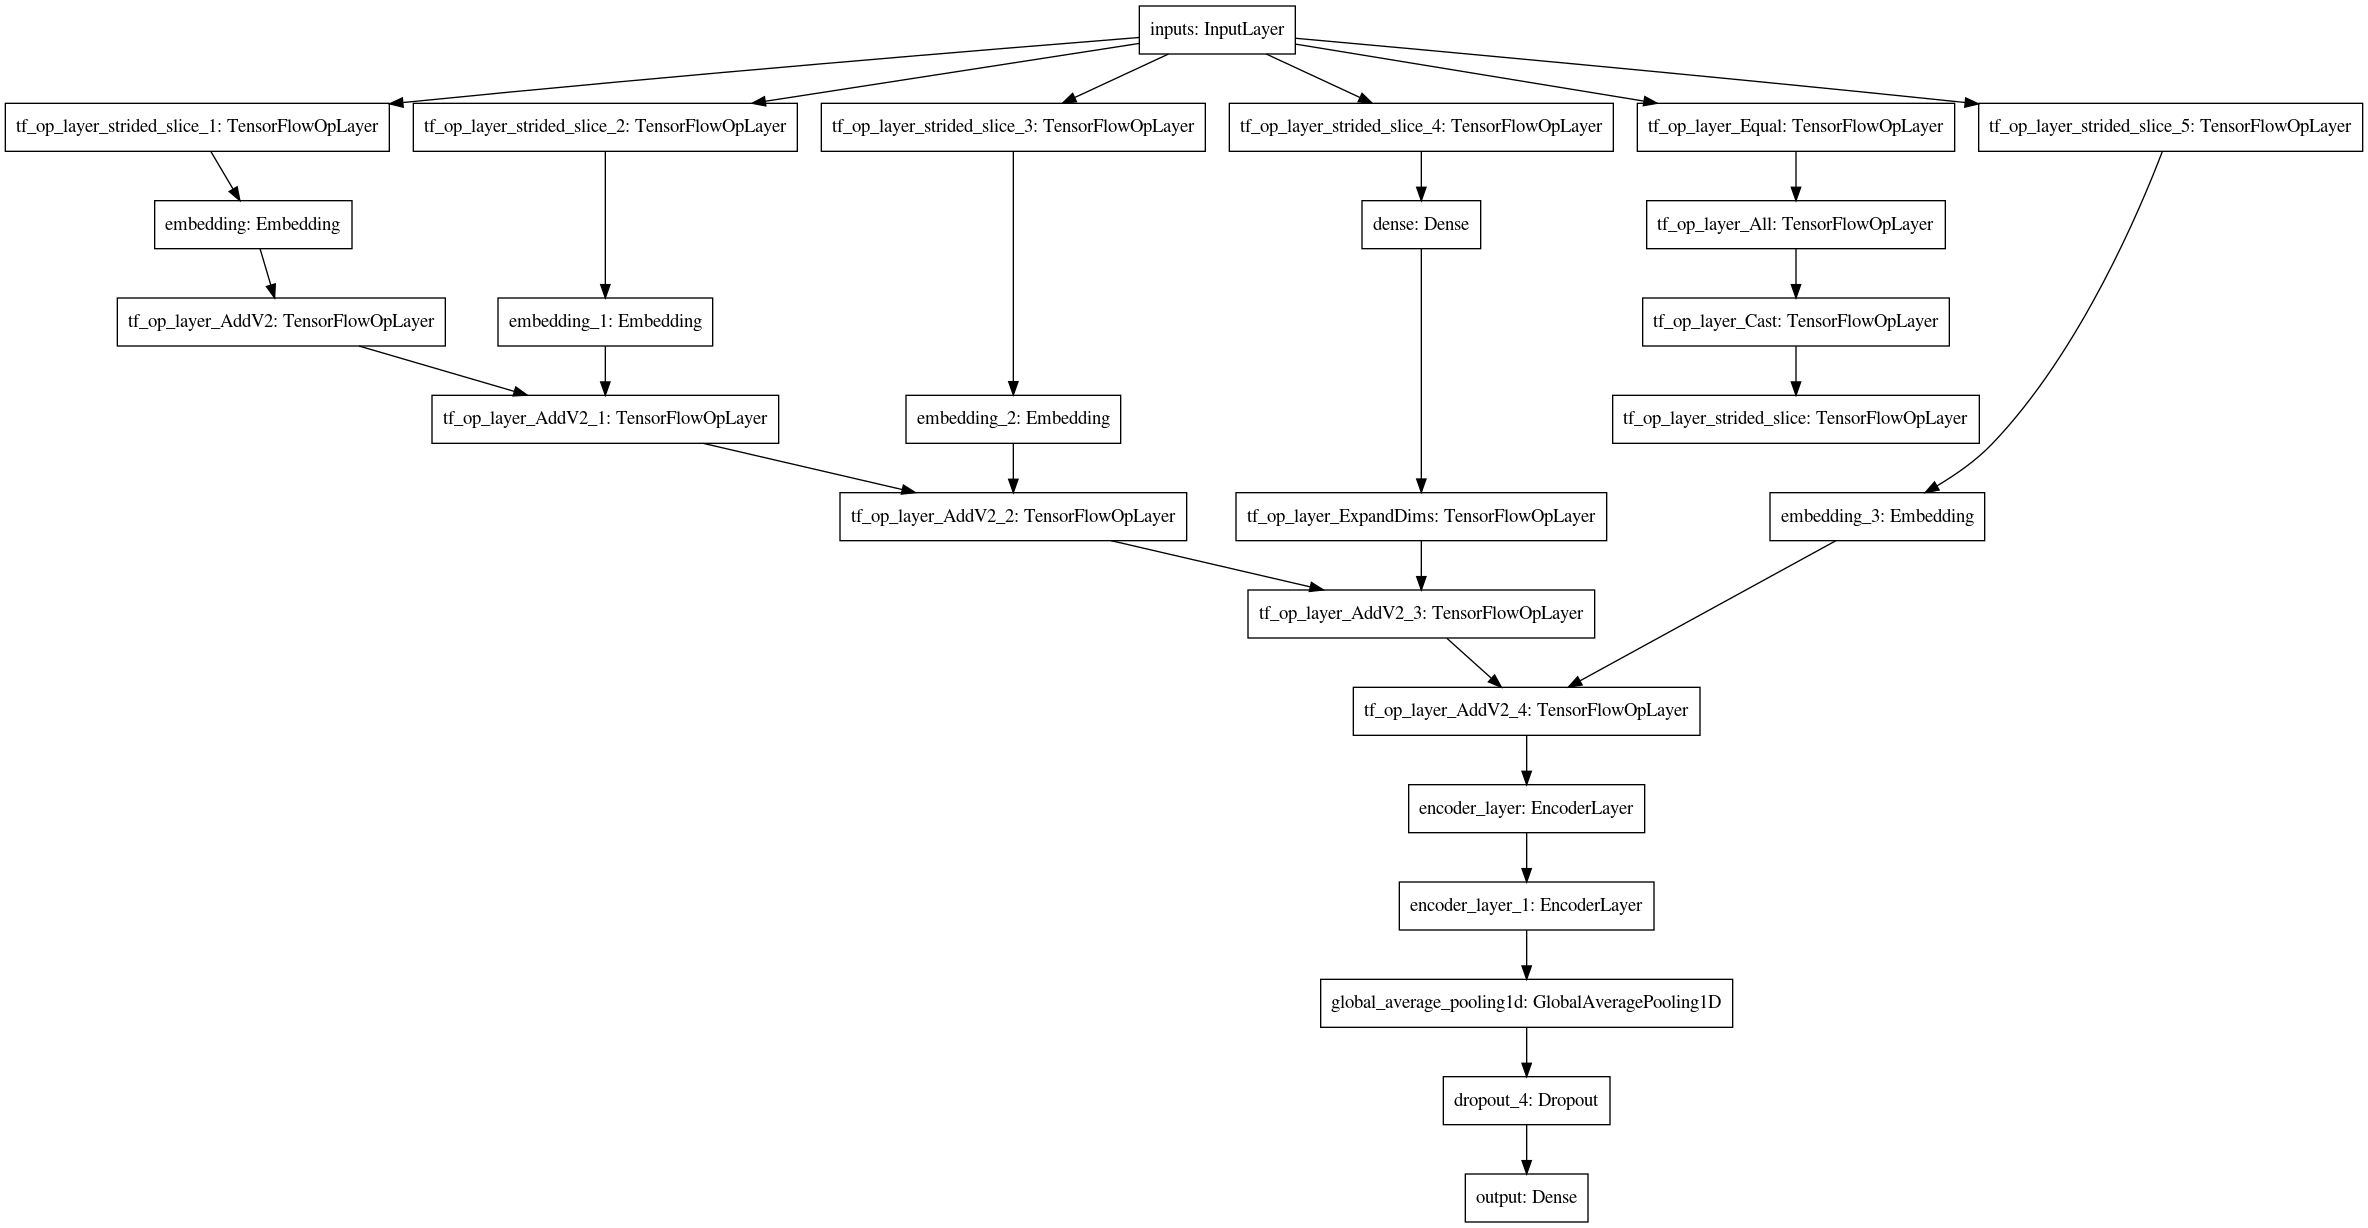

In [17]:
tf.keras.utils.plot_model(model)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 64, 5)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 64)]         0           inputs[0][0]                     
__________________________________________________________________________________________________
embedding (Embedding)           (None, 64, 32)       432768      tf_op_layer_strided_slice_1[0][0]
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [(None, 64)]         0           inputs[0][0]                     
______________________________________________________________________________________________

In [19]:
model.fit(
    s_train,
    validation_data=s_val,
    epochs=epochs,
    workers=4,
    shuffle=True,
    use_multiprocessing=True,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=patience, monitor='val_AUC', mode='max', restore_best_weights=True),
    verbose=1
)
model.save_weights('model.h5')

Epoch 1/300
3059/3059 [==============================] - 93s 30ms/step - loss: 0.6312 - AUC: 0.6179 - acc: 0.6584 - val_loss: 0.5943 - val_AUC: 0.7090 - val_acc: 0.6839
Epoch 2/300
3059/3059 [==============================] - 95s 31ms/step - loss: 0.5850 - AUC: 0.7136 - acc: 0.6951 - val_loss: 0.5834 - val_AUC: 0.7246 - val_acc: 0.6974
Epoch 3/300
3059/3059 [==============================] - 95s 31ms/step - loss: 0.5712 - AUC: 0.7339 - acc: 0.7056 - val_loss: 0.5915 - val_AUC: 0.7214 - val_acc: 0.6950
Epoch 4/300
3059/3059 [==============================] - 95s 31ms/step - loss: 0.5645 - AUC: 0.7425 - acc: 0.7098 - val_loss: 0.5900 - val_AUC: 0.7193 - val_acc: 0.6884


## Inference

First, we load again the training data, but this time we load everything and then tail the users to the last window size interactions.

We apply the same operations than we did before to the training data in this new DataFrame, and also to the test. Also, we develop a logic to add the previous_answered_correctly. 

The only thing we need to make sure is the user_id column in the test dfs is in the same place than the answered_correctly in the train df to make the trick after it in the RiidSequence.

In [20]:
import gc

In [21]:
del s_val
del df
gc.collect()

119

In [22]:
df = pd.read_csv(
    '../input/riiid-test-answer-prediction/train.csv',
    usecols=dtype.keys(),
    dtype=dtype,
    # nrows=10**6
)
df = df[df.answered_correctly!=-1]
df = df.groupby('user_id').tail(windows_size)

In [23]:
df, _, _ = transform_df(df, questions)
df = {uid: u.drop(columns='user_id') for uid, u in df.groupby('user_id')}

In [24]:
import riiideducation

In [25]:
env = riiideducation.make_env()
iter_test = env.iter_test()

In [26]:
columns[columns.index('answered_correctly')] = 'user_id'
columns = [c for c in columns if c not in questions.columns] + ['row_id']
columns

['content_id',
 'task_container_id',
 'user_id',
 'prior_question_elapsed_time',
 'row_id']

In [27]:
for test, sample_prediction in iter_test:
    
    try:
        prior_correct = eval(test['prior_group_answers_correct'].iloc[0])
        prior_correct = [a for a in prior_correct if a != -1]
    except:
        prior_correct = []
    
    # Add prior correct to test and update stored users
    if prior_correct:
        prior_test.insert(s_train.answered_correctly_index, 'answered_correctly', prior_correct)
        for uid, user in prior_test.groupby('user_id'):
            s_train.update_user(
                uid, user.drop(columns='user_id').to_numpy())

    # Filter test
    test = test.loc[
        test['content_type_id'] == 0,
        columns
    ]

    # Add global features
    test, _, _ = transform_df(test, questions)

    # Save test for later
    prior_test = test.drop(columns='row_id').copy()

    # Make x
    x = np.apply_along_axis(
        s_train.get_user_for_inference,
        1,
        test.drop(columns='row_id').to_numpy()
    )

    # Predict
    test['answered_correctly'] = model.predict(x, batch_size=x.shape[0])
    
    env.predict(test[['row_id', 'answered_correctly']])

Luckily with this contribution we can make the highest positions more competitive. Feel free to make use of this, fellas. Also, if you find interesting to make a team, just tell me!

If you feel like there's something I can explain or extend let me know, please, it's a real quick sketch.